**Hyperparameter Search for RNN**


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler
import random
import math
import time
import os
from tqdm import tqdm
from collections import defaultdict

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# Dataset and Preprocessing 

def load_shakespeare_dataset():
    dataset = load_dataset("tiny_shakespeare")
    return dataset

def preprocess_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    return text.lower().split()

def build_vocab(tokenized_text):
    word_counts = {}
    for word in tokenized_text:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    
    # Sort by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in sorted_words:
        word_to_idx[word] = len(word_to_idx)
    
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return word_to_idx, idx_to_word

def create_sequences(tokenized_text, word_to_idx, seq_length=5):
    sequences = []
    targets = []
    
    for i in range(len(tokenized_text) - seq_length):
        seq = tokenized_text[i:i+seq_length]
        target = tokenized_text[i+seq_length]
        
        # Convert words to indices
        seq_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in seq]
        target_idx = word_to_idx.get(target, word_to_idx['<UNK>'])
        
        sequences.append(seq_indices)
        targets.append(target_idx)
    
    return np.array(sequences), np.array(targets)

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.LongTensor(sequences)
        self.targets = torch.LongTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# RNN

class ImprovedRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=1, 
                 dropout_rate=0.0, activation='tanh', weight_init='xavier_uniform'):
        super(ImprovedRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Choose activation function
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()  # Default
        
        # RNN layers
        if num_layers == 1:
            self.rnn = nn.RNN(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=1,
                batch_first=True,
                nonlinearity='tanh' if activation == 'tanh' else 'relu'
            )
            self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        else:
            # For multi-layer RNN, we need to handle dropout between layers
            self.rnn = nn.RNN(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout_rate if num_layers > 1 else 0,
                nonlinearity='tanh' if activation == 'tanh' else 'relu'
            )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.apply(lambda m: self._init_weights(m, weight_init))
    
    def _init_weights(self, module, weight_init):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            if weight_init == 'xavier_uniform':
                nn.init.xavier_uniform_(module.weight)
            elif weight_init == 'xavier_normal':
                nn.init.xavier_normal_(module.weight)
            elif weight_init == 'he_normal':
                nn.init.kaiming_normal_(module.weight)
        elif isinstance(module, nn.RNN):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    if weight_init == 'xavier_uniform':
                        nn.init.xavier_uniform_(param)
                    elif weight_init == 'xavier_normal':
                        nn.init.xavier_normal_(param)
                    elif weight_init == 'he_normal':
                        nn.init.kaiming_normal_(param)
    
    def forward(self, x, hidden=None):
        # Convert input to embeddings
        embedded = self.embedding(x)  
        
        # Initialize hidden state if not provided
        batch_size = x.size(0)
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, 
                                self.hidden_size, device=x.device)
        
        output, hidden = self.rnn(embedded, hidden)
        
        # Apply dropout 
        if hasattr(self, 'dropout'):
            output = self.dropout(output)
        
        # Output layer
        logits = self.fc(output[:, -1, :])
        
        return logits, hidden
    
    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [ ]:
# Evaluation 
def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            hidden = model.init_hidden(sequences.size(0), device)
            output, hidden = model(sequences, hidden)
            loss = criterion(output, targets)
            total_loss += loss.item() * len(targets)
            total_words += len(targets)
    
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)
    
    return perplexity

def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            hidden = model.init_hidden(sequences.size(0), device)
            output, hidden = model(sequences, hidden)
            
            _, predicted = torch.max(output, 1)
            
            # Update counts
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Store for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = correct / total
    return accuracy, all_preds, all_targets

In [ ]:
def plot_confusion_matrix(all_preds, all_targets, idx_to_word, word_to_idx, top_n=10, filename=None):
    """Plot confusion matrix for top N most frequent words"""
    # Get word counts
    word_counts = {}
    for idx in all_targets:
        word = idx_to_word[idx]
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    
    # Get top N words
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_word_indices = [word_to_idx[word] for word, _ in top_words]
    
    filtered_preds = []
    filtered_targets = []
    for i in range(len(all_preds)):
        if all_targets[i] in top_word_indices:
            filtered_preds.append(all_preds[i])
            filtered_targets.append(all_targets[i])
    
    # Compute confusion matrix
    cm = confusion_matrix(filtered_targets, filtered_preds, labels=top_word_indices)
    
    # Plot
    display_labels = [idx_to_word[idx] for idx in top_word_indices]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix for Top Words")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        print(f"Saved confusion matrix to {filename}")
    
    plt.show()

def generate_text(model, seed_text, word_to_idx, idx_to_word, seq_length, num_words=10, device='cpu'):
    model.eval()
    
    # Tokenize the seed text
    words = seed_text.lower().split()
    
    # Convert to indices
    current_sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words[-seq_length:]]
    
    # Generate words
    generated_words = []
    
    with torch.no_grad():
        for _ in range(num_words):

            x = torch.LongTensor(current_sequence).unsqueeze(0).to(device)  # (1, seq_length)
            

            hidden = model.init_hidden(1, device)
            
            # Get predictions
            output, hidden = model(x, hidden)
            
            probs = torch.softmax(output, dim=1)
            predicted_idx = torch.multinomial(probs, 1).item()
            
            predicted_word = idx_to_word[predicted_idx]
            generated_words.append(predicted_word)
            
            # Update sequence
            current_sequence = current_sequence[1:] + [predicted_idx]
    
    result = seed_text + " " + " ".join(generated_words)
    return result

In [ ]:
# Hyperparameter Search 
def random_search_rnn(tokenized_text, word_to_idx, idx_to_word, n_iter=5, cv=2, device='cpu'):

    # Define hyperparameter space
    param_dist = {
        'embedding_size': [50, 100, 200],
        'hidden_size': [64, 128, 256],
        'num_layers': [1, 2],
        'learning_rate': [0.0001, 0.001, 0.01],
        'batch_size': [32, 64, 128],
        'optimizer': ['adam', 'sgd', 'rmsprop'],
        'activation': ['tanh', 'relu'],
        'dropout': [0.0, 0.2, 0.5],
        'weight_init': ['xavier_uniform', 'xavier_normal', 'he_normal']
    }
    
    # Generate random hyperparameter combinations
    random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
    
    # Create sequences
    seq_length = 5
    sequences, targets = create_sequences(tokenized_text, word_to_idx, seq_length)
    
    best_score = float('inf')  # Using validation loss as metric
    best_params = None
    best_model = None
    all_results = []
    
    # Perform random search
    print(f"Running {n_iter} random hyperparameter combinations")
    for param_set in tqdm(random_params):
        # Extract hyperparameters
        embedding_size = param_set['embedding_size']
        hidden_size = param_set['hidden_size']
        num_layers = param_set['num_layers']
        lr = param_set['learning_rate']
        batch_size = param_set['batch_size']
        optimizer_name = param_set['optimizer']
        activation_name = param_set['activation']
        dropout_rate = param_set['dropout']
        weight_init = param_set['weight_init']
        
        # summary string for logging
        param_summary = f"emb={embedding_size}, hid={hidden_size}, layers={num_layers}, lr={lr}, " \
                       f"batch={batch_size}, opt={optimizer_name}, act={activation_name}, " \
                       f"drop={dropout_rate}, init={weight_init}"
        print(f"\nTrying: {param_summary}")
        
        cv_scores = []
        
        for fold in range(cv):
          
            val_size = len(sequences) // cv
            val_start = fold * val_size
            val_end = (fold + 1) * val_size if fold < cv - 1 else len(sequences)
            
            train_sequences = np.concatenate((sequences[:val_start], sequences[val_end:]), axis=0)
            train_targets = np.concatenate((targets[:val_start], targets[val_end:]), axis=0)
            val_sequences = sequences[val_start:val_end]
            val_targets = targets[val_start:val_end]
            

            train_dataset = ShakespeareDataset(train_sequences, train_targets)
            val_dataset = ShakespeareDataset(val_sequences, val_targets)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            vocab_size = len(word_to_idx)
            model = ImprovedRNN(
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout_rate=dropout_rate,
                activation=activation_name,
                weight_init=weight_init
            ).to(device)
            

            if optimizer_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            else:  
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            
            # Training
            criterion = nn.CrossEntropyLoss()
            epochs = 10  
            
            # Train model
            model.train()
            for epoch in range(epochs):
                epoch_loss = 0
                for batched_sequences, batched_targets in train_loader:
                    
                    batched_sequences = batched_sequences.to(device)
                    batched_targets = batched_targets.to(device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    output, _ = model(batched_sequences)
                    
                    # Calculate loss
                    loss = criterion(output, batched_targets)
                    
                    # Backward pass
                    loss.backward()
                    
                    # Clip gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                    
                    # Update parameters
                    optimizer.step()
                    
                    epoch_loss += loss.item()
            
            # Evaluate on validation set
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batched_sequences, batched_targets in val_loader:
                    # Move data to the specified device (GPU or CPU)
                    batched_sequences = batched_sequences.to(device)
                    batched_targets = batched_targets.to(device)
                    
                    output, _ = model(batched_sequences)
                    loss = criterion(output, batched_targets)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            cv_scores.append(avg_val_loss)
            
            print(f"  Fold {fold+1}/{cv} - Validation Loss: {avg_val_loss:.4f}")
        
    
        avg_cv_score = sum(cv_scores) / len(cv_scores)
        print(f"  Average Validation Loss: {avg_cv_score:.4f}")
        
        # Record result
        result = {
            'params': param_set,
            'avg_val_loss': avg_cv_score,
            'val_losses': cv_scores
        }
        all_results.append(result)
        
        # Check if this is the best model so far
        if avg_cv_score < best_score:
            best_score = avg_cv_score
            best_params = param_set
            
            # Train the best model on the full dataset for later use
            train_dataset = ShakespeareDataset(sequences, targets)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            best_model = ImprovedRNN(
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout_rate=dropout_rate,
                activation=activation_name,
                weight_init=weight_init
            ).to(device)
            
            if optimizer_name == 'adam':
                optimizer = optim.Adam(best_model.parameters(), lr=lr)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(best_model.parameters(), lr=lr)
            else:  
                optimizer = optim.RMSprop(best_model.parameters(), lr=lr)
            
            
            epochs = 10
            best_model.train()
            for epoch in range(epochs):
                for batched_sequences, batched_targets in train_loader:
                    # Move data to device
                    batched_sequences = batched_sequences.to(device)
                    batched_targets = batched_targets.to(device)
                    
                    optimizer.zero_grad()
                    output, _ = best_model(batched_sequences)
                    loss = criterion(output, batched_targets)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(best_model.parameters(), 5.0)
                    optimizer.step()
            
            print(f"New best model found! Loss: {avg_cv_score:.4f}")
    
    # Sort results by score
    all_results.sort(key=lambda x: x['avg_val_loss'])
    
    # Print top results
    print("\nTop 5 hyperparameter combinations:")
    for i, result in enumerate(all_results[:min(5, len(all_results))]):
        params = result['params']
        print(f"{i+1}. Loss: {result['avg_val_loss']:.4f} - emb={params['embedding_size']}, " 
              f"hid={params['hidden_size']}, layers={params['num_layers']}, "
              f"lr={params['learning_rate']}, batch={params['batch_size']}, "
              f"opt={params['optimizer']}, act={params['activation']}, "
              f"drop={params['dropout']}, init={params['weight_init']}")
    
    print(f"\nBest hyperparameters: {best_params}")
    print(f"Best validation loss: {best_score:.4f}")
    
    return best_params, best_model, all_results


In [ ]:
def evaluate_best_model(best_model, test_loader, device):
    criterion = nn.CrossEntropyLoss()
    
    #  perplexity
    perplexity = compute_perplexity(best_model, test_loader, criterion, device)
    
    #  accuracy
    accuracy, all_preds, all_targets = compute_accuracy(best_model, test_loader, device)
    
    print(f"Best RNN Model Test Results:")
    print(f"  Perplexity: {perplexity:.2f}")
    print(f"  Accuracy: {accuracy:.4f}")
    
    return perplexity, accuracy, all_preds, all_targets

def plot_loss_curves(train_losses, val_losses, filename=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    plt.tight_layout()
    
    # Save the figure if filename is provided
    if filename:
        plt.savefig(filename)
        print(f"Saved loss curves to {filename}")
    
    # Display the plot
    plt.show()

Using device: cuda
Loading dataset...
Preprocessing text...
Building vocabulary...
Vocabulary size: 21949
Running 5 random hyperparameter combinations...


  0%|          | 0/5 [00:00<?, ?it/s]


Trying: emb=200, hid=256, layers=2, lr=0.001, batch=64, opt=rmsprop, act=relu, drop=0.5, init=xavier_normal
  Fold 1/2 - Validation Loss: 7.5256
  Fold 2/2 - Validation Loss: 7.5651
  Average Validation Loss: 7.5454


 20%|██        | 1/5 [01:18<05:12, 78.08s/it]

  --> New best model found! Loss: 7.5454

Trying: emb=200, hid=64, layers=2, lr=0.01, batch=32, opt=sgd, act=tanh, drop=0.2, init=he_normal
  Fold 1/2 - Validation Loss: 8.0714


 40%|████      | 2/5 [01:52<02:37, 52.58s/it]

  Fold 2/2 - Validation Loss: 8.0541
  Average Validation Loss: 8.0628

Trying: emb=50, hid=64, layers=1, lr=0.01, batch=32, opt=rmsprop, act=relu, drop=0.5, init=he_normal
  Fold 1/2 - Validation Loss: 9.1257


 60%|██████    | 3/5 [02:29<01:30, 45.25s/it]

  Fold 2/2 - Validation Loss: 9.0646
  Average Validation Loss: 9.0951

Trying: emb=200, hid=64, layers=1, lr=0.0001, batch=32, opt=rmsprop, act=relu, drop=0.2, init=xavier_normal
  Fold 1/2 - Validation Loss: 7.6691


 80%|████████  | 4/5 [03:14<00:45, 45.30s/it]

  Fold 2/2 - Validation Loss: 7.7113
  Average Validation Loss: 7.6902

Trying: emb=200, hid=128, layers=2, lr=0.0001, batch=32, opt=adam, act=relu, drop=0.5, init=xavier_normal
  Fold 1/2 - Validation Loss: 7.7832


100%|██████████| 5/5 [04:12<00:00, 50.52s/it]

  Fold 2/2 - Validation Loss: 7.7931
  Average Validation Loss: 7.7882

Top 5 hyperparameter combinations:
1. Loss: 7.5454 - emb=200, hid=256, layers=2, lr=0.001, batch=64, opt=rmsprop, act=relu, drop=0.5, init=xavier_normal
2. Loss: 7.6902 - emb=200, hid=64, layers=1, lr=0.0001, batch=32, opt=rmsprop, act=relu, drop=0.2, init=xavier_normal
3. Loss: 7.7882 - emb=200, hid=128, layers=2, lr=0.0001, batch=32, opt=adam, act=relu, drop=0.5, init=xavier_normal
4. Loss: 8.0628 - emb=200, hid=64, layers=2, lr=0.01, batch=32, opt=sgd, act=tanh, drop=0.2, init=he_normal
5. Loss: 9.0951 - emb=50, hid=64, layers=1, lr=0.01, batch=32, opt=rmsprop, act=relu, drop=0.5, init=he_normal

Best hyperparameters: {'weight_init': 'xavier_normal', 'optimizer': 'rmsprop', 'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 256, 'embedding_size': 200, 'dropout': 0.5, 'batch_size': 64, 'activation': 'relu'}
Best validation loss: 7.5454


Best RNN Model Test Results:
  Perplexity: 675.37
  Accuracy: 0.0809
Saved confusion matrix to confusion_matrix_best_rnn.png


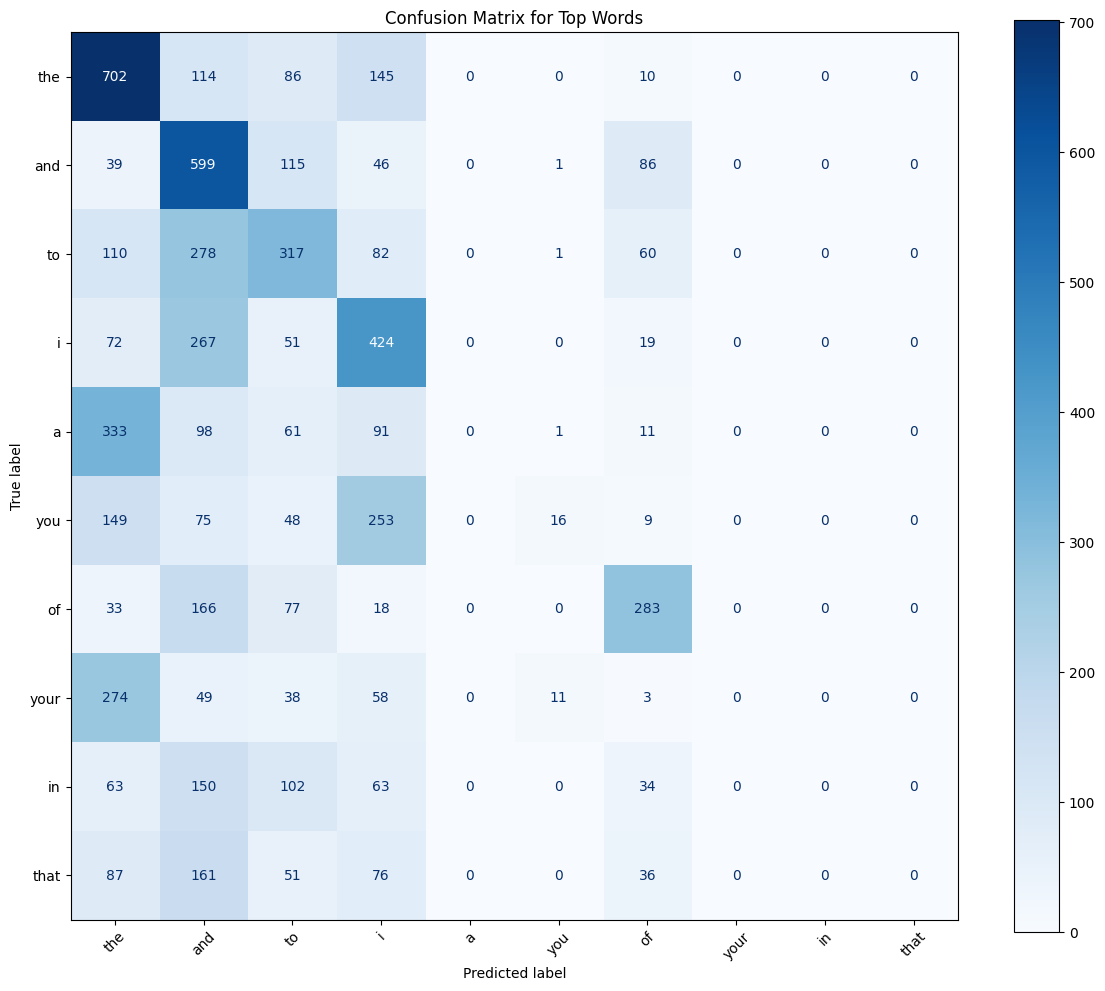

Generated text with best model: to be or not to but impossible, the hearts will 's: the he grey: can we i me see thine head; peter: none, on think

RNN Hyperparameter Search Results
Best hyperparameters: {'weight_init': 'xavier_normal', 'optimizer': 'rmsprop', 'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 256, 'embedding_size': 200, 'dropout': 0.5, 'batch_size': 64, 'activation': 'relu'}
Test perplexity: 675.37
Test accuracy: 0.0809


In [2]:
def run_rnn_hyperparameter_search():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    print("Loading dataset...")
    dataset = load_shakespeare_dataset()
    
    print("Preprocessing text...")
    if 'train' in dataset and 'text' in dataset['train']:
        text = dataset['train']['text']
    elif 'train' in dataset:
        first_item = dataset['train'][0]
        if isinstance(first_item, dict) and 'text' in first_item:
            text = ' '.join([item['text'] for item in dataset['train']])
        else:
            text = str(dataset['train'])
    else:
        raise ValueError("Could not find text data in the dataset")
        
    tokenized_text = preprocess_text(text)

    print("Building vocabulary")
    word_to_idx, idx_to_word = build_vocab(tokenized_text)
    vocab_size = len(word_to_idx)
    print(f"Vocabulary size: {vocab_size}")
    
   
    n_iter = 10
    cv = 3
    
    best_params, best_model, all_results = random_search_rnn(
        tokenized_text, word_to_idx, idx_to_word, n_iter=n_iter, cv=cv, device=device
    )
    

    seq_length = 10
    sequences, targets = create_sequences(tokenized_text, word_to_idx, seq_length)
    
    split_idx = int(0.8 * len(sequences))
    _, test_sequences = sequences[:split_idx], sequences[split_idx:]
    _, test_targets = targets[:split_idx], targets[split_idx:]
    
    test_dataset = ShakespeareDataset(test_sequences, test_targets)
    batch_size = best_params['batch_size']
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

    perplexity, accuracy, all_preds, all_targets = evaluate_best_model(
        best_model, test_loader, device
    )
    
    plot_confusion_matrix(
        all_preds, all_targets, idx_to_word, word_to_idx,
        filename='confusion_matrix_best_rnn.png'
    )
    
    seed_text = "to be or not to"
    generated_text = generate_text(
        best_model, seed_text, word_to_idx, idx_to_word, 
        seq_length, num_words=20, device=device
    )
    print(f"Generated text with best model: {generated_text}")
    
    # Save the best model
    torch.save(best_model.state_dict(), 'best_rnn_model.pt')
    
    # Create results summary
    print("\n" + "="*50)
    print("RNN Hyperparameter Search Results")
    print("="*50)
    print(f"Best hyperparameters: {best_params}")
    print(f"Test perplexity: {perplexity:.2f}")
    print(f"Test accuracy: {accuracy:.4f}")
    print("="*50)
    
   
    return best_params, perplexity, accuracy


if __name__ == "__main__":
    best_params, perplexity, accuracy = run_rnn_hyperparameter_search()

**Hyperparameter Search for CNN**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.initializers import GlorotUniform, HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from tqdm.notebook import tqdm

In [ ]:

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split the training data to create a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#  CNN model with specified hyperparameters
def create_cnn_model(learning_rate, num_conv_layers, num_filters, batch_size, 
                     optimizer_name, activation_function, dropout_rate, 
                     kernel_size, stride, weight_init):
    
    model = Sequential()
    
    if weight_init == 'glorot':
        kernel_initializer = GlorotUniform()
    else:  # 'he'
        kernel_initializer = HeNormal()
    
    # Add convolutional layers based on num_conv_layers parameter
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(num_filters, kernel_size=kernel_size, strides=stride, 
                             activation=activation_function, padding='same',
                             kernel_initializer=kernel_initializer,
                             input_shape=(32, 32, 3)))
        else:
            model.add(Conv2D(num_filters * (i+1), kernel_size=kernel_size, strides=stride, 
                             activation=activation_function, padding='same',
                             kernel_initializer=kernel_initializer))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(128, activation=activation_function, kernel_initializer=kernel_initializer))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_initializer=kernel_initializer))
    
    # Set the optimizer based on the parameter
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:  # 'rmsprop'
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

#  hyperparameter search space
hyperparameter_space = {
    'learning_rate': [0.001, 0.01, 0.0001],
    'num_conv_layers': [2, 3, 4],
    'num_filters': [32, 64, 128],
    'batch_size': [16, 32, 64],
    'optimizer_name': ['adam', 'sgd', 'rmsprop'],
    'activation_function': ['relu', 'tanh', 'sigmoid'],
    'dropout_rate': [0.0, 0.2, 0.4],
    'kernel_size': [(3, 3), (5, 5)],
    'stride': [(1, 1), (2, 2)],
    'weight_init': ['glorot', 'he']
}

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Starting hyperparameter search...


  0%|          | 0/5 [00:00<?, ?it/s]


Iteration 1/5
Parameters: {'learning_rate': 0.0001, 'num_conv_layers': 2, 'num_filters': 32, 'batch_size': 64, 'optimizer_name': 'sgd', 'activation_function': 'relu', 'dropout_rate': 0.0, 'kernel_size': (3, 3), 'stride': (1, 1), 'weight_init': 'glorot'}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.0873 - loss: 2.3052 - val_accuracy: 0.0978 - val_loss: 2.3004
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0947 - loss: 2.2990 - val_accuracy: 0.1054 - val_loss: 2.2958
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1046 - loss: 2.2948 - val_accuracy: 0.1169 - val_loss: 2.2922
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1197 - loss: 2.2914 - val_accuracy: 0.1257 - val_loss: 2.2890
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1265 - loss: 2.2884 - val_accuracy: 0.1277 - val_loss: 2.2862
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1301 - loss: 2.2856 - val_accuracy: 0.1314 - val_loss: 2.2834
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1332 - loss: 2.2829 - val_accuracy: 0.1371 - val_loss: 2.2807
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1386 - loss: 2.2802 - val_accuracy: 0.

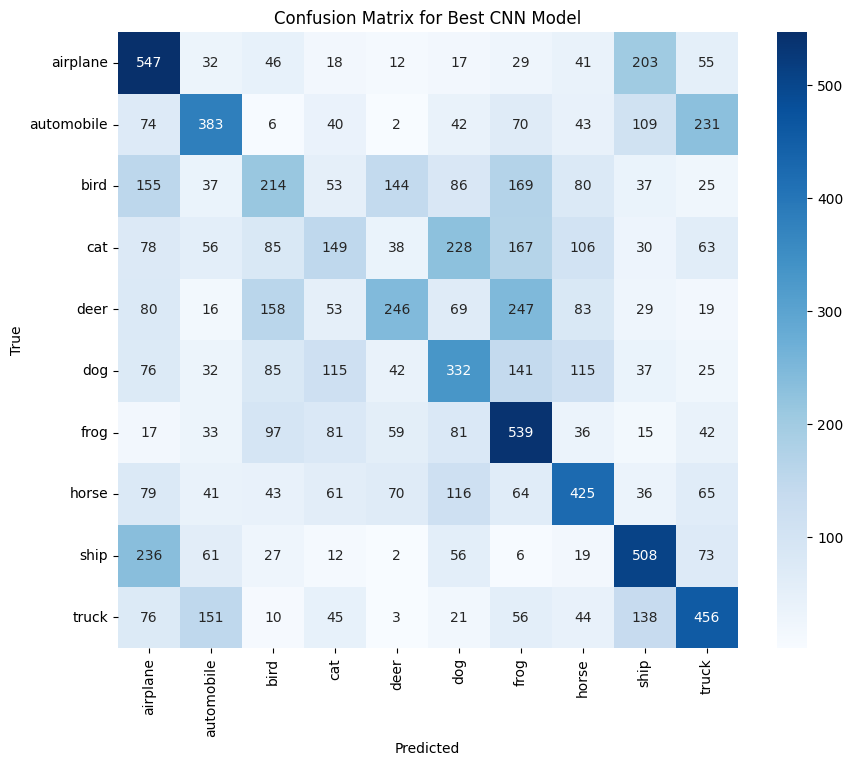

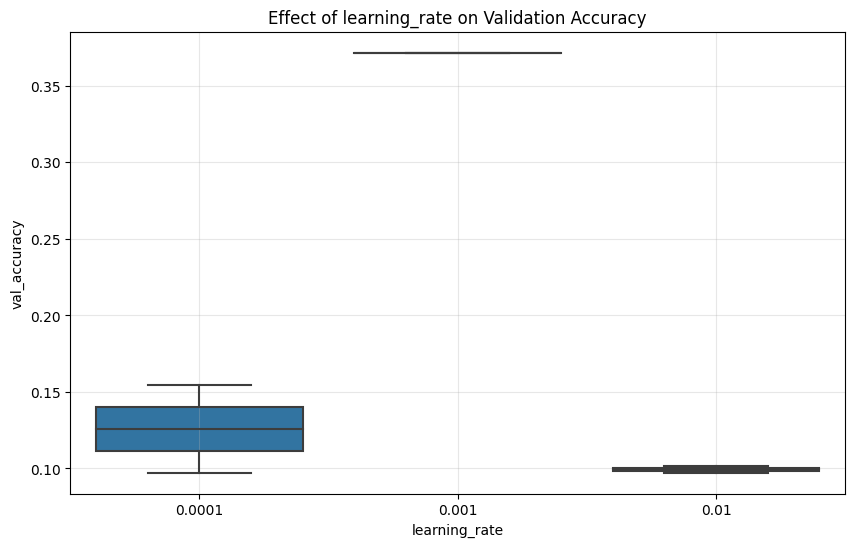

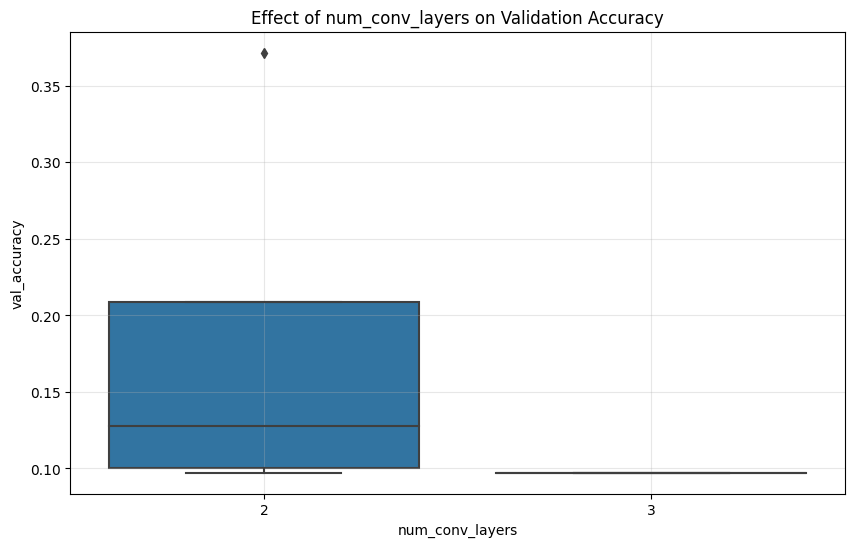

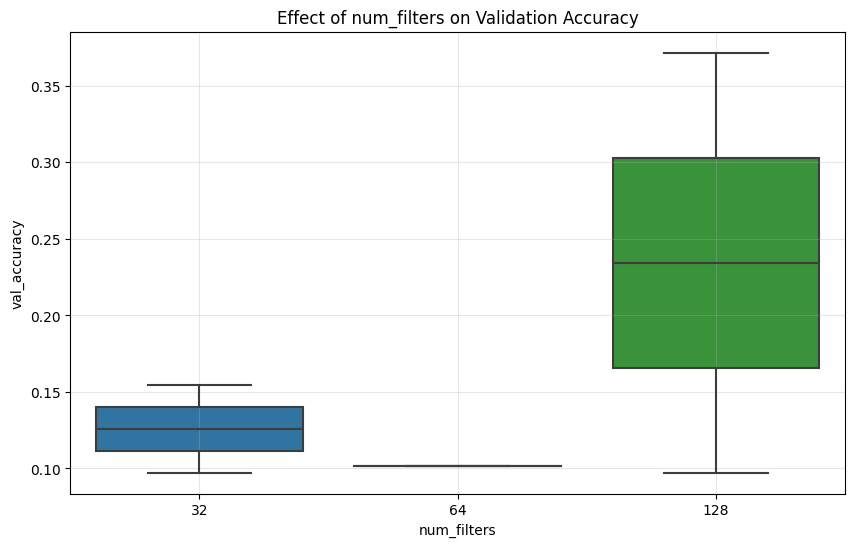

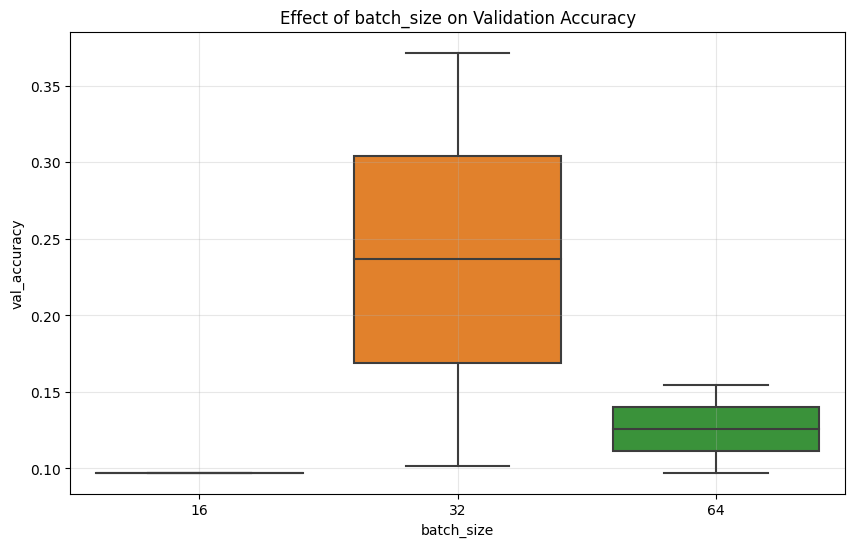

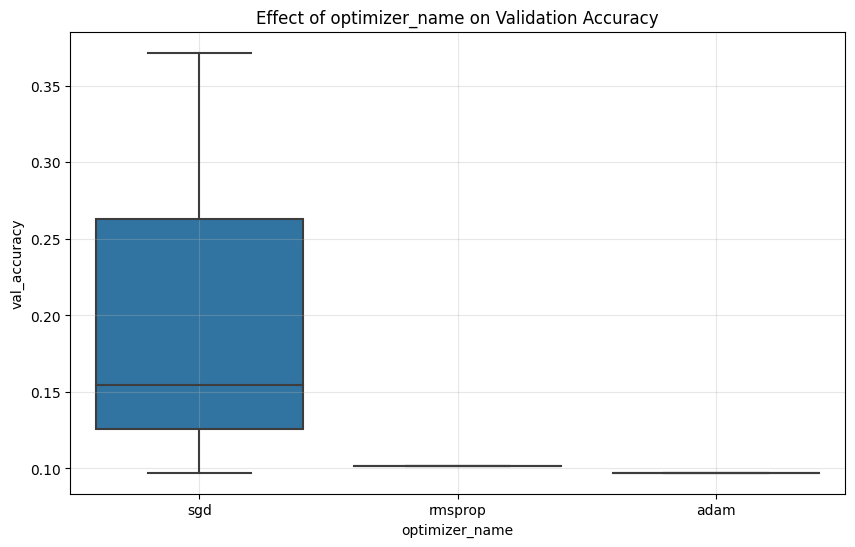

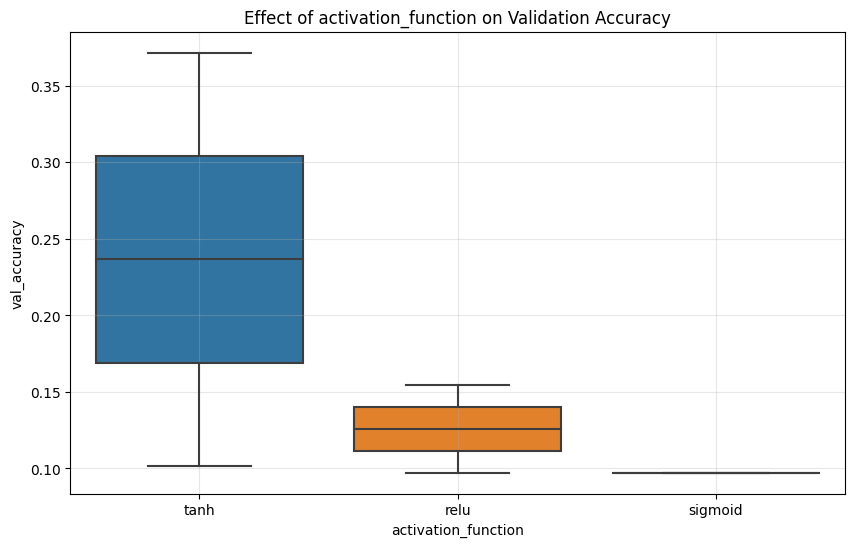

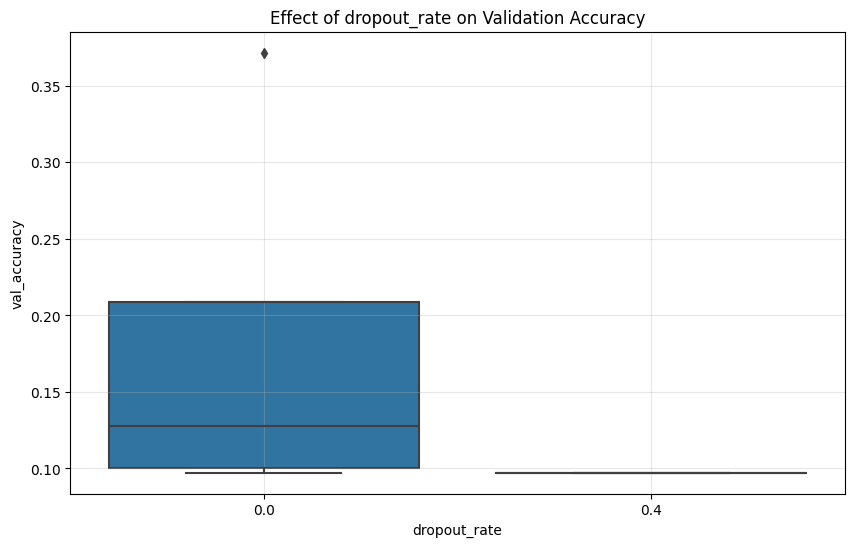

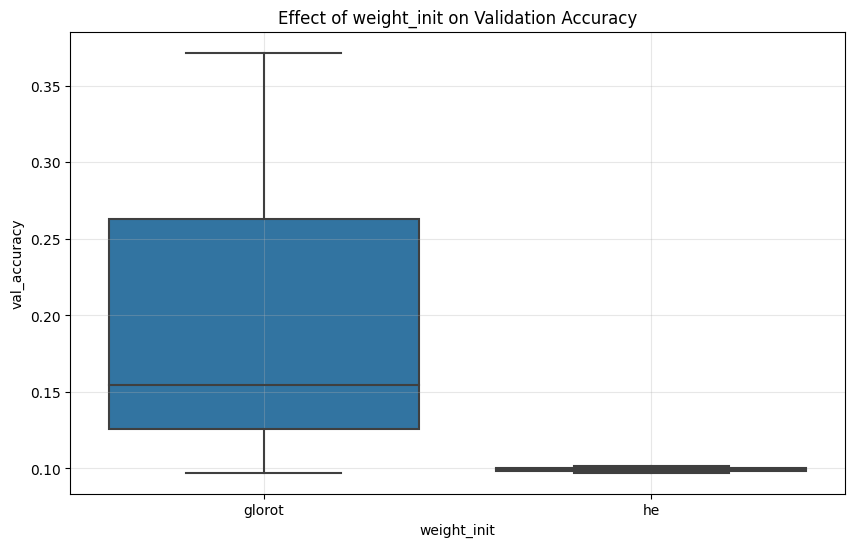

In [1]:
# perform random hyperparameter search
def random_search(n_iterations=10):
    results = []
    best_val_accuracy = 0
    best_model = None
    best_params = None
    
    for i in tqdm(range(n_iterations)):
        # Randomly sample hyperparameters
        params = {
            'learning_rate': random.choice(hyperparameter_space['learning_rate']),
            'num_conv_layers': random.choice(hyperparameter_space['num_conv_layers']),
            'num_filters': random.choice(hyperparameter_space['num_filters']),
            'batch_size': random.choice(hyperparameter_space['batch_size']),
            'optimizer_name': random.choice(hyperparameter_space['optimizer_name']),
            'activation_function': random.choice(hyperparameter_space['activation_function']),
            'dropout_rate': random.choice(hyperparameter_space['dropout_rate']),
            'kernel_size': random.choice(hyperparameter_space['kernel_size']),
            'stride': random.choice(hyperparameter_space['stride']),
            'weight_init': random.choice(hyperparameter_space['weight_init'])
        }
        
        print(f"\nIteration {i+1}/{n_iterations}")
        print(f"Parameters: {params}")
        
        # Create and train the model
        model = create_cnn_model(**params)
        
        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        
        # Train the model
        history = model.fit(
            x_train, y_train,
            batch_size=params['batch_size'],
            epochs=10,  # Limiting to 10 epochs to keep it manageable
            validation_data=(x_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
        
        # Save results
        params['val_accuracy'] = val_accuracy
        params['val_loss'] = val_loss
        results.append(params)
        
        # Check if this is the best model so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_params = params
            
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
    return results, best_model, best_params

# Perform random search
print("Starting hyperparameter search")
search_results, best_model, best_params = random_search(n_iterations=5)  # Reduced to 5 iterations for speed

# Display the results
results_df = pd.DataFrame(search_results)
results_df = results_df.sort_values('val_accuracy', ascending=False).reset_index(drop=True)
print("\nHyperparameter search results (sorted by validation accuracy):")
print(results_df)

print("\nBest hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Evaluate the best model on the test set
y_pred_probs = best_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

#  performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nPerformance metrics for the best model on test data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best CNN Model')
plt.show()


for param in hyperparameter_space.keys():
    if param not in ['kernel_size', 'stride']:  
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=param, y='val_accuracy', data=results_df)
        plt.title(f'Effect of {param} on Validation Accuracy')
        plt.grid(True, alpha=0.3)
        plt.show()